In [1]:
!pip3 uninstall -y opencv-python
!pip3 install opencv-python-headless==4.5.5.64

Found existing installation: opencv-python 4.1.2.30
Uninstalling opencv-python-4.1.2.30:
  Successfully uninstalled opencv-python-4.1.2.30
     |████████████████████████████████| 47.8 MB 80 kB/s 


In [2]:
!pip install -U wandb imgaug albumentations

     |████████████████████████████████| 1.8 MB 5.2 MB/s 
     |████████████████████████████████| 948 kB 35.0 MB/s 
     |████████████████████████████████| 102 kB 51.6 MB/s 
     |████████████████████████████████| 181 kB 36.5 MB/s 
     |████████████████████████████████| 145 kB 21.5 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
     |████████████████████████████████| 60.5 MB 98 kB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=63f9276e957f251e48d995df7859921b4e9cb8dee7f8d039fc5a7378c0f53fe4
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully un

In [1]:
import torch
import os
import cv2
import imgaug as ia
import numpy as np
import sys
import json

from imgaug import augmenters as iaa

from collections import defaultdict

from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.nn import functional as F

from torchvision.models import resnet18 as resnet18
from torchvision import transforms

import matplotlib.pyplot as plt

## Логирование процесса обучения

Будем отправлять логи обучения (значение функции потерь, метрики качества) в сервис Weights & Biases - https://wandb.ai. Тогда к ним можно будет легко получить доступ через интернет и следить за процессом обучения откуда угодно.

In [2]:
import wandb
wandb.init(project="cv-mipt")
None

wandb: Currently logged in as: ivbelkin. Use `wandb login --relogin` to force relogin


## Подготовка данных

Скачиваем датасет транспортных средств https://www.kaggle.com/rishabkoul1/vechicle-dataset. Распаковываем его и указываем корректные пути к данным для обучения и тестирования

In [6]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1eh70EmEGVt2MegQMSHZ3422Az2ITUXlA'
downloaded = drive.CreateFile({'id': file_id})

# Save file to disk
downloaded.GetContentFile('vechicle_with_train.zip')

file_id = '1EwGXc6EgOAmM5pu55gacDny5FJMJOj2i'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('imagenet1000_clsidx_to_labels.json')

file_id = '1hcym9dHjvr3JWsdy6DGqO0yzUGT_p9MZ'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('coco_clsidx_to_labels.json')

In [7]:
!unzip vechicle_with_train.zip

Archive:  vechicle_with_train.zip
  inflating: vechicles/test/bike/Z (2).jpg  
  inflating: vechicles/test/bike/Z (3).jpg  
  inflating: vechicles/test/bike/Z (4).jpg  
  inflating: vechicles/test/bike/Z (5).jpg  
  inflating: vechicles/test/bike/Z (6).jpg  
  inflating: vechicles/test/bike/Z (7).jpg  
  inflating: vechicles/test/bike/Z.jpg  
  inflating: vechicles/test/boat/P8H6OFO4HGgGVcAAAAASUVORK5CYII_.png  
  inflating: vechicles/test/boat/Z (1).jpg  
  inflating: vechicles/test/boat/Z (2).jpg  
  inflating: vechicles/test/boat/Z (3).jpg  
  inflating: vechicles/test/boat/Z (4).jpg  
  inflating: vechicles/test/boat/Z (5).jpg  
  inflating: vechicles/test/boat/Z (6).jpg  
  inflating: vechicles/test/boat/Z (7).jpg  
  inflating: vechicles/test/boat/Z (8).jpg  
  inflating: vechicles/test/boat/Z.jpg  
  inflating: vechicles/test/boat/wPxrijEm7m6PQAAAABJRU5ErkJggg__.png  
  inflating: vechicles/test/bus/Z (10).jpg  
  inflating: vechicles/test/bus/Z (11).jpg  
  inflating: vechicles

In [3]:
TRAIN_DATA_PATH = 'vechicles/train/'
TEST_DATA_PATH = 'vechicles/test/'

Для того, чтобы использовать свой собственный датасет можно привести его к формату одного из общеупотребимых, либо реализовать класс для доступа к нему. Обязательными для реализции являются методы \__getitem__ и \__len__.

Если датасет небольшой, то его можно полностью загрузить в оперативную память. Это позволит максимально эффективно задействовать GPU, так как не нужно будет тратить время на считывание данных с диска

In [4]:
class VehiclesDatasetRAM(Dataset):

    def __init__(self, path, transform=None):
        super().__init__()

        self.path = path
        self.transform = transform

        self.data = []

        self.class_name_to_idx = {}
        self.idx_to_class_name = []

        for class_idx, class_name in enumerate(sorted(os.listdir(path))):
            self.class_name_to_idx[class_name] = class_idx
            self.idx_to_class_name.append(class_name)

            class_images_path = os.path.join(path, class_name)
            for image_name in os.listdir(class_images_path):
                image_path = os.path.join(class_images_path, image_name)
                
                # считывание с диска и декодирование jpeg данных
                image = cv2.imread(image_path, cv2.IMREAD_COLOR)
                
                self.data.append((image, class_name))

    def __getitem__(self, idx):
        image, class_name = self.data[idx]
        if self.transform:
            image = self.transform(image)
        return image, self.class_name_to_idx[class_name]

    def __len__(self):
        return len(self.data)

Если датасет большой, то придется считывать данные с диска по мере необходимости. Если одна итерация обучения модели занимает меньше времени, чем загрузка данных, то такой подход будет приводить к простою GPU.

In [5]:
class VehiclesDatasetDisk(Dataset):

    def __init__(self, path, transform=None):
        super().__init__()

        self.path = path
        self.transform = transform

        self.data = []

        self.class_name_to_idx = {}
        self.idx_to_class_name = []

        for class_idx, class_name in enumerate(sorted(os.listdir(path))):
            self.class_name_to_idx[class_name] = class_idx
            self.idx_to_class_name.append(class_name)

            class_images_path = os.path.join(path, class_name)
            for image_name in os.listdir(class_images_path):
                image_path = os.path.join(class_images_path, image_name)
                
                # просто запоминаем путь к изображению, считывание произведем потом
                self.data.append((image_path, class_name))

    def __getitem__(self, idx):
        image_path, class_name = self.data[idx]
        # считывание с диска и декодирование jpeg данных
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        if self.transform:
            image = self.transform(image)
        return image, self.class_name_to_idx[class_name]

    def __len__(self):
        return len(self.data)

Как правило, изображения на диске хранятся в сжатом формате, а при считывании разжимаются. Можно отложить декомпрессию изображения до непосредственного обращения к нему. При этом в память загрузить бинарные данные, представляющие сжатые изображения. Такой подход применим для датасетов среднего размера.

In [6]:
class VehiclesDatasetRAMCompressed(Dataset):

    def __init__(self, path, transform=None):
        super().__init__()

        self.path = path
        self.transform = transform

        self.data = []

        self.class_name_to_idx = {}
        self.idx_to_class_name = []

        for class_idx, class_name in enumerate(sorted(os.listdir(path))):
            self.class_name_to_idx[class_name] = class_idx
            self.idx_to_class_name.append(class_name)

            class_images_path = os.path.join(path, class_name)
            for image_name in os.listdir(class_images_path):
                image_path = os.path.join(class_images_path, image_name)
                
                # считывание с диска последовательности байт
                with open(image_path, 'rb') as f:
                    data = np.asarray(bytearray(f.read()), dtype=np.uint8)
                
                self.data.append((data, class_name))

    def __getitem__(self, idx):
        data, class_name = self.data[idx]
        # декодирование jpeg данных
        image = cv2.imdecode(data, cv2.IMREAD_COLOR)
        if self.transform:
            image = self.transform(image)
        return image, self.class_name_to_idx[class_name]

    def __len__(self):
        return len(self.data)

Как правило, перед подачей изображения на вход сети его необходимо предобработать, в том числе применить аугментации для обучающих данных.

In [7]:
train_transform = transforms.Compose([
    iaa.Sequential([
        iaa.Fliplr(0.5),
        iaa.CoarseSaltAndPepper(0.05, size_percent=(0.01, 0.2)),
        iaa.CenterCropToSquare(),
        iaa.Resize({"height": 128, "width": 128})
    ]).augment_image,
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

test_transform = transforms.Compose([
    iaa.Sequential([
        iaa.CenterCropToSquare(),
        iaa.Resize({"height": 128, "width": 128})
    ]).augment_image,
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [8]:
train_dataset = VehiclesDatasetRAM(TRAIN_DATA_PATH, train_transform)
test_dataset = VehiclesDatasetRAM(TEST_DATA_PATH, test_transform)

print('Train dataset size:', len(train_dataset))
print('Test dataset size:', len(test_dataset))

Train dataset size: 528
Test dataset size: 74


Доступ к элементам датасета осуществляется по индексу, при этом вызывается метод \__getitem__

Image shape: torch.Size([3, 128, 128])
Class idx: 0
Class name: bike


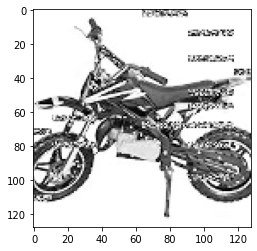

In [9]:
image, class_idx = train_dataset[0]

print('Image shape:', image.shape)
print('Class idx:', class_idx)
print('Class name:', train_dataset.idx_to_class_name[class_idx])

plt.imshow(image[0], cmap='Greys_r')

In [10]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,  # обучающие данные стоит передавать в случайном порядке
    num_workers=2,  # число потоков подготовки данных. если не удается полностью задействовать GPU, то можно попробовать увеличить, но это увеличит нагрузку на cpu
    pin_memory=True,  # перевод GPU памяти в режим pinned ускоряет загрузку/выгрузку данных
    drop_last=True  # чтобы все батчи были одного размера, лучше сделать True
)

test_dataloader = DataLoader(
    test_dataset,  
    batch_size=8, 
    shuffle=False,
    num_workers=1, 
    pin_memory=True, 
    drop_last=False  # чтобы обработать все тестовые данные
)

Объект класса DataLoader является итерируемым и возвращает батчи данных

In [11]:
for batch in test_dataloader:
    break

In [12]:
image_batch, class_idx_batch = batch

print('Image batch size:', image_batch.shape)
print('Class index batch size:', class_idx_batch.shape)

Image batch size: torch.Size([8, 3, 128, 128])
Class index batch size: torch.Size([8])


## Подготовка модели

В качестве модели будем использовать ResNet18, предобученную на датасете ImageNet:

In [13]:
model = resnet18(pretrained=True)

In [14]:
with open('imagenet1000_clsidx_to_labels.json', 'r') as f:
    imagenet1k_clsidx_to_labels = json.load(f)

Проверим, какие результаты показывает предобученная модель до дообучения:

In [15]:
logits = model(image_batch)
topk = torch.topk(logits, 5)

In [16]:
def show_res(idx):
    plt.imshow(image_batch[idx, 0], cmap='Greys_r')
    print('True label:', train_dataset.idx_to_class_name[class_idx_batch[idx]])
    print('Model labels:', [imagenet1k_clsidx_to_labels[i] for i in topk.indices[idx]])

True label: bike
Model labels: ['milk can', 'coffeemaker', 'water jug', 'salt shaker', 'water bottle']


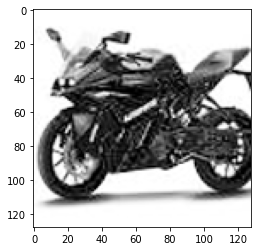

In [17]:
show_res(0)

True label: bike
Model labels: ['crayfish', 'chain', 'scorpion', 'spindle', 'agama']


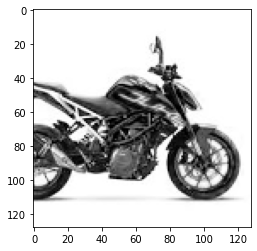

In [18]:
show_res(1)

True label: bike
Model labels: ['barn spider', 'American robin', 'honeycomb', 'yellow garden spider', 'goldfish']


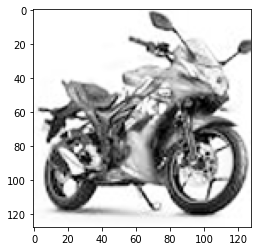

In [19]:
show_res(2)

В целевом датасете 10 классов, поэтому заменим последний слой

In [20]:
model.fc = nn.Linear(512, 10)
torch.nn.init.xavier_normal_(model.fc.weight)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Большая часть модели (кроме последнего слоя), уже достаточно хорошо обучена. Последний слой при этом инициализирован случайными величинами. Поэтому, чтобы в процессе обучения не испортить уже обученные веса, можно их заморозить и дообучить только последний слой:

In [21]:
# Замораживаем все веса модели
for param in model.parameters():
    param.requires_grad = False

# Размораживаем последний линейный слой
for param in model.fc.parameters():
    param.requires_grad = True

При этом полное число параметров модели будет составлять

In [22]:
print('Total number of parameters:', sum(param.numel() for param in model.parameters()))

Total number of parameters: 11181642


Из которых обучаемыми являются всего 512 * 10 + 10 = 5130

In [23]:
print('Number of trainable parameters:', sum(param.numel() for param in model.parameters() if param.requires_grad))

Number of trainable parameters: 5130


In [24]:
if torch.cuda.is_available():
    print('CUDA is available!')
    model = model.cuda()

CUDA is available!


## Обучение

Для обучения необходимо создать оптимизатор, он будет обновлять веса, для которых requires_grad = True, в процессе обучения. Кроме SGD можно использовать другие доступные оптимизаторы (https://pytorch.org/docs/stable/optim.html), или реализовать свой.

In [25]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Параметры SGD необходимо аккуратно подбирать. Рекомендации приведены в работе: https://arxiv.org/abs/1803.09820. Либо сделать выбор в сторону адаптивных методов (Adam, ...)

Оптимизатор, также как и модели, содержит state_dict, содержащий параметры оптимизатора. Его можно сохранить на диск и загрузить обратно в точности так же, как и веса модели.

Изменение параметров (learning_rate, momentum, и т.д.) напрямую влияет на процесс обучения

In [26]:
sd = optimizer.state_dict()
sd['param_groups'][0]['lr'], sd['param_groups'][0]['momentum']

(0.001, 0.9)

Можно изменять их напрямую, но более правильным является использование scheduler (см. https://pytorch.org/docs/stable/optim.html)
Больше методов изменения скорости обучения доступно в https://pytorch.org/ignite/handlers.html#parameter-scheduler

В качестве показателя качества будем использовать точность классификации (accuracy). Результаты её вычисления будем отправлять на wandb сервер

In [27]:
def accuracy_wb(dataloader, model, label):
    model = model.eval()
    tp = 0
    with torch.no_grad():
        for batch in dataloader:
            image_batch, class_idx_batch = batch
            if torch.cuda.is_available():
                image_batch = image_batch.cuda()
                class_idx_batch = class_idx_batch.cuda()
            
            logits = model(image_batch)
            classes = torch.argmax(logits, dim=1)
            tp += (class_idx_batch == classes).sum().item()

        acc = tp / len(dataloader.dataset)
        wandb.log({label: acc})
        print(label, acc)

Запустим процесс обучения

In [28]:
def train(model, num_epochs, prefix):
    for epoch in range(num_epochs):
        print('\nEpoch', epoch)
        model = model.train()

        for batch in train_dataloader:
            # в pytorch градиент хранится в переменной grad и вычисляется при вызове backward
            # при этом он не перезаписывается, а добавляется к старому значению,
            # поэтому необходимо приравнять grad нулю, перед вычислением градиентов
            optimizer.zero_grad()
            
            image_batch, class_idx_batch = batch
            if torch.cuda.is_available():
                image_batch = image_batch.cuda()
                class_idx_batch = class_idx_batch.cuda()

            logits = model(image_batch)

            # вычисляем функцию потерь
            loss = F.cross_entropy(logits, class_idx_batch)

            # вычисляем градиенты
            loss.backward()

            wandb.log({'train_loss': loss})

            # выполняем шаг оптимизации - обновляем веса
            optimizer.step()

        # считаем и логируем метрики качества
        accuracy_wb(train_dataloader, model, 'train_accuracy')
        accuracy_wb(test_dataloader, model, 'test_accuracy')

        # сохраняем промежуточные результаты обучения - веса модели и состояние оптимизатора,
        # чтобы при необходимости возобновить обучение с них
        torch.save(model.state_dict(), prefix + 'model_{}.pth'.format(epoch))
        torch.save(optimizer.state_dict(), prefix + 'optimizer_{}.pth'.format(epoch))

## Stage 1 - обучение линейного слоя

In [29]:
train(model, 20, 'stage_1_')


Epoch 0
train_accuracy 0.4753787878787879
test_accuracy 0.47297297297297297

Epoch 1
train_accuracy 0.6098484848484849
test_accuracy 0.6216216216216216

Epoch 2
train_accuracy 0.7215909090909091
test_accuracy 0.6351351351351351

Epoch 3
train_accuracy 0.7045454545454546
test_accuracy 0.6891891891891891

Epoch 4
train_accuracy 0.7443181818181818
test_accuracy 0.6351351351351351

Epoch 5
train_accuracy 0.7727272727272727
test_accuracy 0.7027027027027027

Epoch 6
train_accuracy 0.8125
test_accuracy 0.7567567567567568

Epoch 7
train_accuracy 0.8106060606060606
test_accuracy 0.7837837837837838

Epoch 8
train_accuracy 0.8200757575757576
test_accuracy 0.7162162162162162

Epoch 9
train_accuracy 0.8314393939393939
test_accuracy 0.7162162162162162

Epoch 10
train_accuracy 0.821969696969697
test_accuracy 0.7432432432432432

Epoch 11
train_accuracy 0.8731060606060606
test_accuracy 0.7297297297297297

Epoch 12
train_accuracy 0.8579545454545454
test_accuracy 0.7432432432432432

Epoch 13
train_accur

## Stage 2 - дообучение последнего сверточного слоя

Загрузим веса, например, с 18-ой эпохи

In [30]:
model.load_state_dict(torch.load('stage_1_model_18.pth'))
optimizer.load_state_dict(torch.load('stage_1_optimizer_18.pth'))

Разморозим дополнительно последний сверточный слой

In [31]:
for param in model.layer4.parameters():
    param.requires_grad = True

Количество обучаемых параметров при этом составит

In [32]:
print('Number of trainable parameters:', sum(param.numel() for param in model.parameters() if param.requires_grad))

Number of trainable parameters: 8398858


Также уменьшим скорость обучения, например в 10 раз

In [33]:
sd = optimizer.state_dict()
sd['param_groups'][0]['lr'] = 0.0001
optimizer.load_state_dict(sd)

In [34]:
train(model, 20, 'stage_2_')


Epoch 0
train_accuracy 0.8882575757575758
test_accuracy 0.7432432432432432

Epoch 1
train_accuracy 0.9147727272727273
test_accuracy 0.7837837837837838

Epoch 2
train_accuracy 0.9337121212121212
test_accuracy 0.7567567567567568

Epoch 3
train_accuracy 0.9393939393939394
test_accuracy 0.7297297297297297

Epoch 4
train_accuracy 0.9412878787878788
test_accuracy 0.7297297297297297

Epoch 5
train_accuracy 0.9431818181818182
test_accuracy 0.7432432432432432

Epoch 6
train_accuracy 0.9488636363636364
test_accuracy 0.7567567567567568

Epoch 7
train_accuracy 0.9734848484848485
test_accuracy 0.7702702702702703

Epoch 8
train_accuracy 0.9640151515151515
test_accuracy 0.7567567567567568

Epoch 9
train_accuracy 0.9678030303030303
test_accuracy 0.7567567567567568

Epoch 10
train_accuracy 0.9621212121212122
test_accuracy 0.7567567567567568

Epoch 11
train_accuracy 0.9734848484848485
test_accuracy 0.7837837837837838

Epoch 12
train_accuracy 0.9791666666666666
test_accuracy 0.7567567567567568

Epoch 13

## Бонус: аккумулирование градиентов

In [35]:
wandb.init(project="cv-mipt")
None

test_accuracy,▁▄▄▆▄▆▇█▆▆▇▇▇▇▆█▆█▇▇▇█▇▇▇▇▇▇▇▇▇█▇███▇▇█▇
train_accuracy,▁▃▄▄▅▅▆▆▆▆▆▆▆▆▆▇▆▆▆▇▇▇▇▇▇▇▇█████████████
train_loss,█▅▅▅▅▃▃▂▃▄▄▃▂▄▅▂▂▃▄▃▂▄▂▂▄▂▂▂▂▂▁▃▂▁▁▂▁▂▃▁
test_accuracy,0.77027
train_accuracy,0.98864
train_loss,0.24138


Как правило, обучение моделей производится на нескольких GPU с большим размером батча. В условиях ограниченных ресурсов приходится уменьшать размер батча. Это приводит к более зашумленной оценке градиента и, зачастую, более низким показателям качества итоговой модели. Стандартной рекомендацией является пропорциональное уменьшение скорости обучения. То есть, при уменьшении размера батча в 8 раз, стоит уменьшить learning rate в 8 раз. Это правило эмпирическое и не гарантирует результат.

Другим выходом является аккумулирование градиентов. Оно заключается в вычислении среднего градиента по нескольким батчам, с последующим выполнением шага оптимизации

In [36]:
def train_ga(model, num_epochs, prefix, num_steps):
    for epoch in range(num_epochs):
        print('\nEpoch', epoch)
        model = model.train()

        optimizer.zero_grad()

        for i, batch in enumerate(train_dataloader):
            image_batch, class_idx_batch = batch
            if torch.cuda.is_available():
                image_batch = image_batch.cuda()
                class_idx_batch = class_idx_batch.cuda()

            logits = model(image_batch)

            # вычисляем функцию потерь
            loss = F.cross_entropy(logits, class_idx_batch) / num_steps

            # вычисляем градиенты
            # в pytorch градиент хранится в переменной grad и вычисляется при вызове backward
            # при этом он не перезаписывается, а добавляется к старому значению
            loss.backward()

            wandb.log({'train_loss': loss})

            if (i + 1) % num_steps == 0:
                # выполняем шаг оптимизации - обновляем веса
                optimizer.step()
                optimizer.zero_grad()

        # считаем и логируем метрики качества
        accuracy_wb(train_dataloader, model, 'train_accuracy')
        accuracy_wb(test_dataloader, model, 'test_accuracy')

        # сохраняем промежуточные результаты обучения - веса модели и состояние оптимизатора,
        # чтобы при необходимости возобновить обучение с них
        torch.save(model.state_dict(), prefix + 'model_{}.pth'.format(epoch))
        torch.save(optimizer.state_dict(), prefix + 'optimizer_{}.pth'.format(epoch))

In [37]:
model.fc = nn.Linear(512, 10)
torch.nn.init.xavier_normal_(model.fc.weight)

if torch.cuda.is_available():
    model = model.cuda()

for param in model.parameters():
    param.requires_grad = False

for param in model.fc.parameters():
    param.requires_grad = True

optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [38]:
train_ga(model, 50, 'ga_', 10)


Epoch 0
train_accuracy 0.0946969696969697
test_accuracy 0.0945945945945946

Epoch 1
train_accuracy 0.11742424242424243
test_accuracy 0.16216216216216217

Epoch 2
train_accuracy 0.1875
test_accuracy 0.20270270270270271

Epoch 3
train_accuracy 0.2859848484848485
test_accuracy 0.28378378378378377

Epoch 4
train_accuracy 0.3390151515151515
test_accuracy 0.36486486486486486

Epoch 5
train_accuracy 0.38636363636363635
test_accuracy 0.43243243243243246

Epoch 6
train_accuracy 0.4431818181818182
test_accuracy 0.43243243243243246

Epoch 7
train_accuracy 0.5416666666666666
test_accuracy 0.5

Epoch 8
train_accuracy 0.5757575757575758
test_accuracy 0.5135135135135135

Epoch 9
train_accuracy 0.6174242424242424
test_accuracy 0.527027027027027

Epoch 10
train_accuracy 0.6496212121212122
test_accuracy 0.527027027027027

Epoch 11
train_accuracy 0.6534090909090909
test_accuracy 0.527027027027027

Epoch 12
train_accuracy 0.6931818181818182
test_accuracy 0.5540540540540541

Epoch 13
train_accuracy 0.6988